# Анализ

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import nltk
import imblearn
import transformers as ppb
import torch

# После токенизации


# Предобработка
from pymystem3 import Mystem
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoTokenizer, AutoModel
from tqdm import notebook
from sklearn.utils import shuffle
import torch
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
# в проверке моделей на эффективность. после токенизации
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
# Обучение
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RepeatedStratifiedKFold
# Тест
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, mean_absolute_error, f1_score, roc_curve, roc_auc_score, auc, accuracy_score
# индикатор важности признаков
from sklearn.ensemble import RandomForestClassifier
# Machine learning models. Модели для объединения
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
# Model evaluation. Алгоритм объединения
from sklearn.ensemble import VotingClassifier

# Модели для сравнения
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

# Remove warnings
import warnings
warnings.filterwarnings('ignore')


In [4]:
file_path = 'chd_addmit_300.xlsx'
data = pd.read_excel(file_path)

# отбор признаков
data = data.loc[:, ['target','Операция (основная / первая в ИБ)']]

,target,Операция (основная / первая в ИБ)
0,0,Перевязка ранее наложенного анастомоза по Blal...


# Предобработка.

In [8]:
# Делаем заглушки
for col in data.columns.tolist():
  if data[col].dtypes in ['float64', 'int64']:
    data[col] = data[col].fillna(data[col].median())

for col in data.columns.tolist():
  if data[col].dtypes == 'object':
    data[col] = data[col].fillna('Нет данных')
    

In [9]:
# Функция для очистки текста от лишних символов
def clean_text(text):
    # приводим текст к нижнему регистру
    text = text.lower()
    # создаем регулярное выражение для удаления лишних символов
    regular = r'[\*+\#+\№\"\-+\+\=+\?+\&\^\.+\;\,+\>+\(\)\/+\:\\+]'
    # регулярное выражение для замены ссылки на "URL"
    regular_url = r'(http\S+)|(www\S+)|([\w\d]+www\S+)|([\w\d]+http\S+)'
    # удаляем лишние символы
    text = re.sub(regular, '', text)
    # заменяем ссылки на "URL"
    text = re.sub(regular_url, r'URL', text)
    # заменяем числа и цифры на ' NUM '
    text = re.sub(r'(\d+\s\d+)|(\d+)',' NUM ', text)
    # удаляем лишние пробелы
    text = re.sub(r'\s+', ' ', text)
    # возвращаем очищенные данные
    return text

In [10]:
# инициализируем токенизатор
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
# экземпляр модели
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
%%time
# создаем список для хранения очищенных данных
cleaned_text = []
# для каждого сообщения text из столбца data[col]
for text in data['Операция (основная / первая в ИБ)']:
    # очищаем данные  
    text = clean_text(text)
    # добавляем очищенные данные в список cleaned_text
    cleaned_text.append(text)
# записываем очищенные данные в новую колонку
data['Операция (основная / первая в ИБ)'] = cleaned_text
# токенизируем текст
data['Операция (основная / первая в ИБ)'] = data['Операция (основная / первая в ИБ)'].apply(lambda x: tokenizer.encode(x,
                                                         add_special_tokens=True,
                                                         truncation=True,
                                                         max_length=512))  
# токенизированный текст
tokenized = data[col]

# применим padding к векторам
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
# англ. вектор с отступами
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

# создадим маску для важных токенов
attention_mask = np.where(padded != 0, 1, 0)
print('attention_mask:',attention_mask.shape)

batch_size = 10

# создаем эмбеддинги
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])      
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:,0,:].numpy())
        

attention_mask: (300, 402)


  0%|          | 0/30 [00:00<?, ?it/s]

embeddings_list: 1
Wall time: 4min 23s


Algorithm: LightGBM, Score: 0.914039408866995, Std: 0.08905959135978497


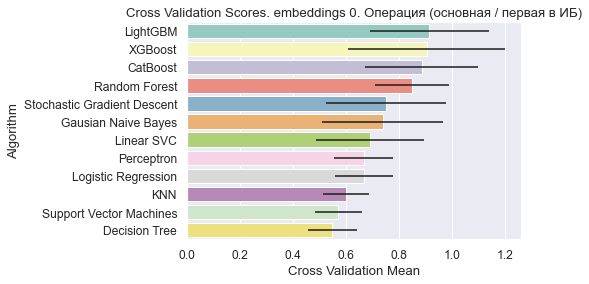

Wall time: 5min 8s


In [53]:
%%time
# проверим какая модель эффективнее
features = np.concatenate(embeddings)
X, y = features, data['target']

classifiers = []
classifiers.append(LogisticRegression())
classifiers.append(SVC())
classifiers.append(KNeighborsClassifier(n_neighbors = 5))
classifiers.append(GaussianNB())
classifiers.append(Perceptron())
classifiers.append(LinearSVC())
classifiers.append(SGDClassifier())
classifiers.append(DecisionTreeClassifier())
classifiers.append(RandomForestClassifier())
classifiers.append(CatBoostClassifier(silent=True))
classifiers.append(LGBMClassifier())
classifiers.append(XGBClassifier())


cv_results = []
for classifier in classifiers:
    cv = StratifiedKFold(n_splits=10, shuffle=True)
    cv_results.append(cross_val_score(classifier, X, y, scoring = 'roc_auc', cv = cv))

cv_mean = []
cv_std = []
for cv_result in cv_results:
    cv_mean.append(cv_result.mean())
    cv_std.append(cv_result.std())
      
cv_res = pd.DataFrame({'Cross Validation Mean': cv_mean, 
                        'Cross Validation Std': cv_std, 
                        'Algorithm': ['Logistic Regression', 'Support Vector Machines',
                                      'KNN', 'Gausian Naive Bayes', 
                                      'Perceptron', 'Linear SVC', 
                                      'Stochastic Gradient Descent', 'Decision Tree', 
                                      'Random Forest', 'CatBoost', 
                                      'LightGBM', 'XGBoost'
                                      ]})
cv_res.sort_values(by = 'Cross Validation Mean', ascending = False, ignore_index = True)

sns.barplot(x='Cross Validation Mean', y='Algorithm', 
              data = cv_res, order = cv_res.sort_values(by = 'Cross Validation Mean', 
                                                        ascending = False)['Algorithm'], 
              palette = 'Set3', **{'xerr': cv_std})
plt.ylabel('Algorithm')
x = data.loc[:,'Операции (все в ИБ)':].columns.tolist()[i]
plt.title(f'Cross Validation Scores. embeddings {i}. {x}')

result = cv_res.sort_values('Cross Validation Mean', ascending=False).reset_index()
a, sc,st =  result['Algorithm'][0], result['Cross Validation Mean'][0], result['Cross Validation Std'][0]
print(f'Algorithm: {a}, Score: {sc}, Std: {st}')
plt.show()

# Модель

In [45]:
X_train, X_test, y_train, y_test = train_test_split(features, data['target'], 
                                                      test_size=0.1, 
                                                      random_state=5,
                                                      stratify=data['target'])
# RandomOverSampler. Балансируем классы!
X_train, y_train = RandomOverSampler(sampling_strategy='minority').fit_resample(X_train, y_train)
X_train, y_train = shuffle(X_train, y_train)
y_train = y_train.reset_index(drop=True)

print(f'Количество строк по классам: {np.bincount(data.target)}')
print(f"Количество строк в y_train по классам: {np.bincount(y_train)}")
print(f"Количество строк в y_test по классам: {np.bincount(y_test)}")

Количество строк по классам: [286  14]
Количество строк в y_train по классам: [257 257]
Количество строк в y_test по классам: [29  1]


In [46]:
%%time
xb = XGBClassifier()
param_grid = {'max_depth': [3, 4, 5, 7, 10, 25],
              'n_estimators': [50, 100, 150],
              'gamma': [0, 0.1, 0.2, 1, 5, 25],
              'min_child_weight': [0, 0.5, 1, 3, 5, 10, 25],
              }

cv = StratifiedKFold(n_splits=3, shuffle=True)
clf_xb = GridSearchCV(xb, param_grid = param_grid, cv = cv, verbose = True, n_jobs = -1)
best_clf_xb = clf_xb.fit(X_train,y_train)
best_clf_xb.best_params_


Fitting 3 folds for each of 756 candidates, totalling 2268 fits
Wall time: 6min 11s


{'gamma': 0, 'max_depth': 3, 'min_child_weight': 0, 'n_estimators': 50}

# Тест

Algorithm: XGBoost, Score: 0.8223432143577334, Std: 0.18409570694206498


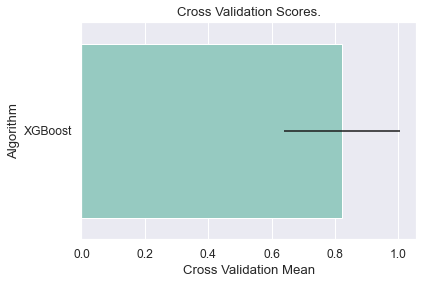

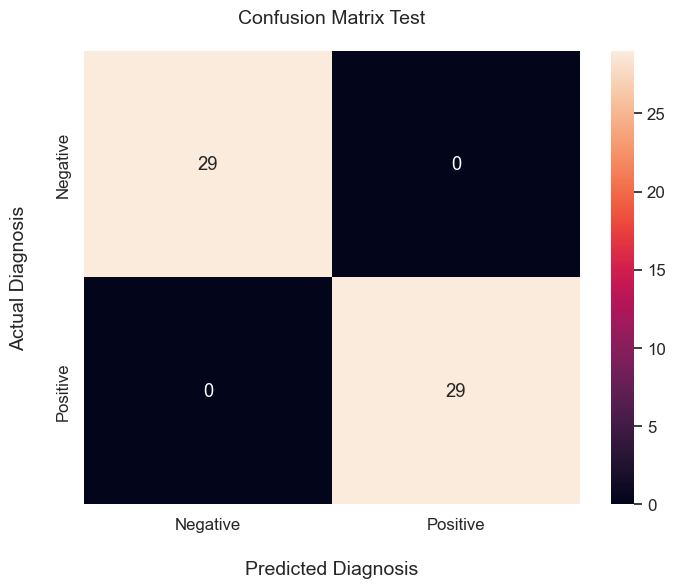

DummyClassifier: 0.50
accuracy_score: 1.0
AUC-ROC: 1.00


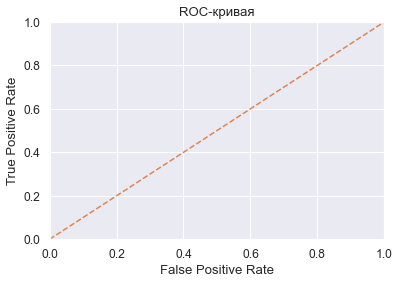

In [58]:
# RandomOverSampler. Балансируем классы!
X_test, y_test = RandomOverSampler(sampling_strategy='minority').fit_resample(X_test, y_test)
X_test, y_test = shuffle(X_test, y_test)
y_test = y_test.reset_index(drop=True)

model = XGBClassifier(gamma=0, max_depth=3, min_child_weight=0, n_estimators=50).fit(X_train, y_train)

# проверим модель на эффективность. Выводим график
for i in range(len(embeddings_list)):

  classifiers = []
  classifiers.append(XGBClassifier(gamma=0, max_depth=3, min_child_weight=0, n_estimators=50))


  cv_results = []
  for classifier in classifiers:
      cv_results.append(cross_val_score(classifier, X, y, scoring = 'roc_auc', cv = 5))

  cv_mean = []
  cv_std = []
  for cv_result in cv_results:
      cv_mean.append(cv_result.mean())
      cv_std.append(cv_result.std())
      
  cv_res = pd.DataFrame({'Cross Validation Mean': cv_mean, 
                        'Cross Validation Std': cv_std, 
                        'Algorithm': ['XGBoost']})
  cv_res.sort_values(by = 'Cross Validation Mean', ascending = False, ignore_index = True)

  sns.barplot(x='Cross Validation Mean', y='Algorithm', 
              data = cv_res, order = cv_res.sort_values(by = 'Cross Validation Mean', 
                                                        ascending = False)['Algorithm'], 
              palette = 'Set3', **{'xerr': cv_std})
  plt.ylabel('Algorithm')
  plt.title(f'Cross Validation Scores.')

  result = cv_res.sort_values('Cross Validation Mean', ascending=False).reset_index()
  a, sc,st =  result['Algorithm'][0], result['Cross Validation Mean'][0], result['Cross Validation Std'][0]
  print(f'Algorithm: {a}, Score: {sc}, Std: {st}')
  plt.show()

# проверим модель на эффективность. Выводим матрицу ошибок
plt.figure(figsize=(8,6), dpi=100)
sns.set(font_scale = 1.1)
ax = sns.heatmap(confusion_matrix(y_test, model.predict(X_test)), annot=True, fmt='d', )
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Negative', 'Positive'])
ax.set_title("Confusion Matrix Test", fontsize=14, pad=20)
plt.show()


clf = DummyClassifier(strategy='most_frequent', random_state=5)
clf.fit(X_train, y_train)
print("DummyClassifier: %.2f" % clf.score(X_test, y_test))
print('accuracy_score:', accuracy_score(y_test ,[round(value) for value in model.predict(X_test)]))
print("AUC-ROC: %.2f" % roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

# Roc кривая
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()